In [1]:
import pandas as pd
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from xgboost import XGBRegressor

import time
import my_tools
import pickle

In [2]:
def evaluate_model(model, X, y, scoring, n_jobs, n_splits=10, n_repeats=3, random_state=1, error_score='raise'):
    
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    n_scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score)

    return mean(n_scores), std(n_scores)

def evaluate_model_complex(model, X, y, scoring, n_jobs, n_splits=10, n_repeats=3, random_state=1):
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)

    return scores

with open('vh_burn_costs.pickle', 'rb') as target:
	vehicle_ratings = pickle.load(target)

In [3]:
try:
    raw = pd.read_csv("W:/Shared With Me/Gibraltar/OTHER/AI Crowd Competition/Data/training.csv")
except:
    raw = pd.read_csv("C:/Users/Dev Work/Documents/aicrowd/insurancepricing/python/training.csv")

In [19]:
# Preprocessing, geting rid of stuff we really dont want.
data = raw.copy()
data = my_tools.clean(data)
data = data[data['year'] == 1]
data = data[data['claim_amount'] > 0]
data = data.merge(vehicle_ratings, on="vh_make_model", how="left").copy()

y = data['claim_amount']
y_minor_claims = y[y <= 150]
y_major_claims = y[(5000 >= y) & (y > 150)]
y_large_loss   = y[y > 5000]

exclude = ['claim_amount', 
            'id_policy', 
            'pol_no_claims_discount',
            'pol_duration',
            'pol_coverage', 
            'pol_payd', 
            'pol_pay_freq', 
            'pol_usage', 
            'vh_fuel', 
            'vh_make_model', 
            'vh_type', 
            'drv_age1',
            'drv_age_lic1',
            'drv_sex1', 
            'drv_drv2', 
            'drv_age2', 
            'drv_age_lic2', 
            'drv_sex2',
            'population',
            'town_surface_area',
            'year']

x_minor_claims = data[data['claim_amount'] <= 150][['vh_value', 'pol_sit_duration']]
x_major_claims = data[(5000 >= data['claim_amount']) & (data['claim_amount'] > 150)][['vh_value', 'pol_sit_duration']]
x_large_loss   = data[data['claim_amount'] > 5000][['vh_value', 'pol_sit_duration']]


In [20]:
x_minor_claims.columns

Index(['vh_value', 'pol_sit_duration'], dtype='object')

In [21]:
# Data setup
x_train_minor_claims, x_test_minor_claims, y_train_minor_claims, y_test_minor_claims = train_test_split(x_minor_claims, y_minor_claims)

x_train_major_claims, x_test_major_claims, y_train_major_claims, y_test_major_claims = train_test_split(x_major_claims, y_major_claims)

x_train_large_loss, y_train_large_loss, x_test_large_loss, y_test_large_loss  =        train_test_split(x_large_loss, y_large_loss)

In [22]:
# Model Setup
n_trees = [50, 100] #[10,100,1000,5000]
max_depth = [2,4,8] #[x for x in range(1,12,2)]
learning_rate = [0.2, 0.4, 0.6,0.8,1]

In [39]:
'''
Warning, this cell will take a very, very long time to run without a decent PC.

I'd recommend not running on laptops...

'''
def fit_model(x_train, y_train, x_test, y_test):
    trees = {}

    names = list()

    start = time.time()

    for n in n_trees:
        depths = {}
        for i in max_depth:
            results = {}
            for r in learning_rate:

                print(f"Tree: {n}, Depth: {i}, Learning Rate: {r}...")

                xg = XGBRegressor(n_estimators=n, max_depth=i, eta=r, eval_metric='logloss')
                xg.fit(x_train, y_train)

                scores = evaluate_model(xg, x_test, y_test, 'neg_mean_absolute_error', -1)

                results[r] = {"scores":scores, "model":xg}

            depths[i] = results.copy()
        trees[n] = depths.copy()

    end = time.time()

    print(f"Time Taken: {end-start}")

    return trees

In [40]:
models_minor_claims = fit_model(x_train_minor_claims, y_train_minor_claims, x_test_minor_claims, y_test_minor_claims)
models_major_claims = fit_model(x_train_major_claims, y_train_major_claims, x_test_major_claims, y_test_major_claims)
#models_large_loss   = fit_model(x_train_large_loss  , y_train_large_loss  , x_test_large_loss  , y_test_large_loss  )

Tree: 50, Depth: 2, Learning Rate: 0.2...
Tree: 50, Depth: 2, Learning Rate: 0.4...
Tree: 50, Depth: 2, Learning Rate: 0.6...
Tree: 50, Depth: 2, Learning Rate: 0.8...
Tree: 50, Depth: 2, Learning Rate: 1...
Tree: 50, Depth: 4, Learning Rate: 0.2...
Tree: 50, Depth: 4, Learning Rate: 0.4...
Tree: 50, Depth: 4, Learning Rate: 0.6...
Tree: 50, Depth: 4, Learning Rate: 0.8...
Tree: 50, Depth: 4, Learning Rate: 1...
Tree: 50, Depth: 8, Learning Rate: 0.2...
Tree: 50, Depth: 8, Learning Rate: 0.4...
Tree: 50, Depth: 8, Learning Rate: 0.6...
Tree: 50, Depth: 8, Learning Rate: 0.8...
Tree: 50, Depth: 8, Learning Rate: 1...
Tree: 100, Depth: 2, Learning Rate: 0.2...
Tree: 100, Depth: 2, Learning Rate: 0.4...
Tree: 100, Depth: 2, Learning Rate: 0.6...
Tree: 100, Depth: 2, Learning Rate: 0.8...
Tree: 100, Depth: 2, Learning Rate: 1...
Tree: 100, Depth: 4, Learning Rate: 0.2...
Tree: 100, Depth: 4, Learning Rate: 0.4...
Tree: 100, Depth: 4, Learning Rate: 0.6...
Tree: 100, Depth: 4, Learning Rate

In [25]:
def process_results(trees):
    rows = []

    for tree in trees:
        for depth in trees[tree]:
            for rate in trees[tree][depth]:
                rows.append((tree, depth, rate, mean(trees[tree][depth][rate]['scores'])))

    processed_data = pd.DataFrame(rows, columns=['trees', 'depth', 'rate', 'mean'])

    return processed_data


In [26]:
results_minor_claims = process_results(models_minor_claims)
results_major_claims = process_results(models_major_claims)
#results_large_loss   = process_results(models_large_loss  )

In [27]:
def find_peak_models(data, trees):
    peak_data = data[data['mean'] == data['mean'].max()]
    peak_models = []

    for row_tuple in peak_data.iterrows():
        row = row_tuple[1]
        peak_models.append(trees[row['trees']][row['depth']][row['rate']]['model'])

    return peak_models

In [28]:
final_model_minor_claims = find_peak_models(results_minor_claims, models_minor_claims)
final_model_major_claims = find_peak_models(results_major_claims, models_major_claims)
#final_model_large_loss   = find_peak_models(results_large_loss  , models_large_loss  )

In [29]:
final_model_minor_claims_results = pd.DataFrame({"predictions": final_model_minor_claims[0].predict(x_minor_claims), "Test Data":y_minor_claims})
final_model_major_claims_results = pd.DataFrame({"predictions": final_model_major_claims[0].predict(x_major_claims), "Test Data":y_major_claims})

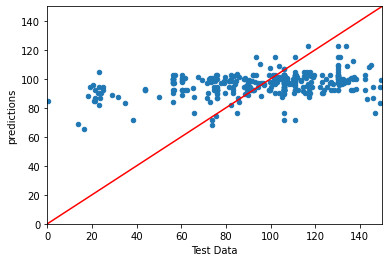

In [30]:
final_model_minor_claims_results.plot(kind="scatter", x="Test Data", y="predictions", xlim=(0,150), ylim=(0,150))
plt.plot(range(0,151),range(0,151),c="red")

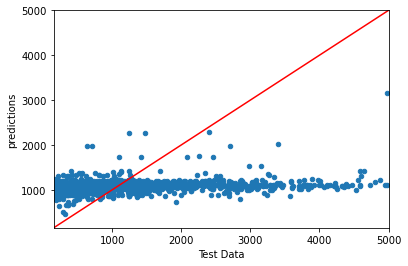

In [31]:
final_model_major_claims_results.plot(kind="scatter", x="Test Data", y="predictions", xlim=(150,5000), ylim=(150,5000))
plt.plot(range(150,5001),range(150,5001),c="red")

In [37]:
results_major_claims['mean'].max()

results_major_claims[results_major_claims['mean'] == results_major_claims['mean'].max()]

,trees,depth,rate,mean
0,50,2,0.2,-300.105558


In [ ]:
for model in peak_models:
    with open('regression_severity_model.pickle', 'wb') as target:
        pickle.dump(model, target)